In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('simulation_data.csv')
data.head()

,k3,k4,k5,k6,class
0,-0.452744,-0.582004,-0.582004,-0.452744,Overshoot
1,-0.250516,0.686300,-0.039354,0.135301,Undershoot
2,-0.399387,0.708746,0.498897,0.708746,Singularity
3,0.149704,0.149704,0.032483,0.032483,Ideal
4,-0.033138,0.504122,0.040915,0.220249,Undershoot


In [3]:
map_data = {'Overshoot': 1, 'Undershoot': 2, 'Ideal': 3, 'Singularity': 4, 'Abnormal': 5}
data['class'] = data['class'].map(map_data)

In [4]:
data

,k3,k4,k5,k6,class
0,-0.452744,-0.582004,-0.582004,-0.452744,1
1,-0.250516,0.686300,-0.039354,0.135301,2
2,-0.399387,0.708746,0.498897,0.708746,4
3,0.149704,0.149704,0.032483,0.032483,3
4,-0.033138,0.504122,0.040915,0.220249,2
...,...,...,...,...,...
1499995,0.259645,0.028643,0.233821,0.214161,1
1499996,456143.342435,89004.676071,79153.249457,920308.283299,5
1499997,0.807450,0.011104,0.081955,0.016689,1
1499998,-0.186917,-0.255762,-0.255762,-0.186917,1


In [5]:
def one_hot_encode_sklearn(data, column_name):
    """
    One-hot encode using scikit-learn's OneHotEncoder.
    
    Parameters:
    data (pandas.DataFrame): Input DataFrame
    column_name (str): Name of the column to encode
    
    Returns:
    pandas.DataFrame: DataFrame with one-hot encoded column
    """
    # Reshape data for encoder
    X = data[column_name].values.reshape(-1, 1)
    
    # Create and fit the encoder
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(X)
    
    # Create new column names
    feature_names = encoder.get_feature_names_out([column_name])

    print(encoded)
    print(feature_names)
    # Create DataFrame with encoded values
    encoded_df = pd.DataFrame(encoded, columns=feature_names, index=data.index)
    
    # Combine with original data
    result = pd.concat([data.drop(column_name, axis=1), encoded_df], axis=1)
    
    return result

In [6]:
encoded_df = one_hot_encode_sklearn(data=data, column_name='class')

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
['class_1' 'class_2' 'class_3' 'class_4' 'class_5']


In [7]:
encoded_df

,k3,k4,k5,k6,class_1,class_2,class_3,class_4,class_5
0,-0.452744,-0.582004,-0.582004,-0.452744,1.0,0.0,0.0,0.0,0.0
1,-0.250516,0.686300,-0.039354,0.135301,0.0,1.0,0.0,0.0,0.0
2,-0.399387,0.708746,0.498897,0.708746,0.0,0.0,0.0,1.0,0.0
3,0.149704,0.149704,0.032483,0.032483,0.0,0.0,1.0,0.0,0.0
4,-0.033138,0.504122,0.040915,0.220249,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1499995,0.259645,0.028643,0.233821,0.214161,1.0,0.0,0.0,0.0,0.0
1499996,456143.342435,89004.676071,79153.249457,920308.283299,0.0,0.0,0.0,0.0,1.0
1499997,0.807450,0.011104,0.081955,0.016689,1.0,0.0,0.0,0.0,0.0
1499998,-0.186917,-0.255762,-0.255762,-0.186917,1.0,0.0,0.0,0.0,0.0


In [8]:
import xgboost as xgb
from xgboost import XGBRegressor  # for regression
from xgboost import XGBClassifier # for classification
from sklearn.model_selection import train_test_split


# Prepare your data
# targets = ['Overshoot', 'Undershoot', 'Ideal', 'Singularity']
targets = ['class_1', 'class_2', 'class_3', 'class_4', 'class_5']
X = encoded_df.drop(targets, axis=1)
y = encoded_df[targets]

# First split: separate test set (20% of total data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, # 20% for testing
    random_state=42
)

# Second split: divide remaining data into train and validation (80% train, 20% validation of remaining data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2, # 20% of the X_temp for validation ==> 16% for validation and 64% for training
    random_state=42
)

-------------
### Getting to know the training data

In [ ]:
print('Total entries in the data = ', len(data))

In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head()

In [ ]:
print('Number of overshoot : ', np.sum(train_df['class_1']))
print('Number of undershoot : ', np.sum(train_df['class_2']))
print('Number of Ideal : ', np.sum(train_df['class_3']))
print('Number of Singularity : ', np.sum(train_df['class_4']))
print('Number of Abnormal : ', np.sum(train_df['class_5']))

In [ ]:
# plt.figure()
# plt.hist(data['class'])
# plt.xticks(['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])
# plt.show()
# Get value counts of the classes
class_counts = data['class'].value_counts()

plt.figure()
plt.bar(range(len(class_counts)), class_counts.values, width=0.3)
plt.ylabel('count')
plt.xticks(range(len(class_counts)), ['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])
plt.show()

-------------------

In [27]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    # 'max_depth': 3,
    # 'learning_rate': 0.1,
    'learning_rate': 0.1, 'max_depth': 7,
    'objective': 'binary:logistic',  # for classification
    'eval_metric': 'logloss',
    'tree_method' : 'gpu_hist'
}

# Specify evaluation sets
evals = [(dtrain, 'train'), (dval, 'validation')]

In [28]:
# Train model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    # num_boost_round=100,
    num_boost_round = 200,
    evals=evals,
    # early_stopping_rounds=20,
    verbose_eval=True
)

[0]	train-logloss:0.44170	validation-logloss:0.44168
[1]	train-logloss:0.39604	validation-logloss:0.39601
[2]	train-logloss:0.35504	validation-logloss:0.35503
[3]	train-logloss:0.32502	validation-logloss:0.32499


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:00:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[4]	train-logloss:0.29617	validation-logloss:0.29615
[5]	train-logloss:0.27467	validation-logloss:0.27463
[6]	train-logloss:0.25575	validation-logloss:0.25570
[7]	train-logloss:0.23626	validation-logloss:0.23621
[8]	train-logloss:0.21953	validation-logloss:0.21950
[9]	train-logloss:0.20515	validation-logloss:0.20513
[10]	train-logloss:0.19196	validation-logloss:0.19198
[11]	train-logloss:0.18081	validation-logloss:0.18083
[12]	train-logloss:0.17088	validation-logloss:0.17091
[13]	train-logloss:0.16146	validation-logloss:0.16151
[14]	train-logloss:0.15335	validation-logloss:0.15342
[15]	train-logloss:0.14573	validation-logloss:0.14581
[16]	train-logloss:0.13896	validation-logloss:0.13903
[17]	train-logloss:0.13248	validation-logloss:0.13256
[18]	train-logloss:0.12689	validation-logloss:0.12697
[19]	train-logloss:0.12154	validation-logloss:0.12163
[20]	train-logloss:0.11637	validation-logloss:0.11643
[21]	train-logloss:0.11210	validation-logloss:0.11219
[22]	train-logloss:0.10747	validat

-----------------------------------------
### Wrapper for tuning the hyperparameters using grid search (GridSearchCV of scikit-learn)
This block of codes can be ignored when first testing to train the xgboost

In [ ]:
from sklearn.model_selection import GridSearchCV

# # Create a custom callback for learning rate decay
# def learning_rate_decay(boosting_round, decay_factor=0.5):
#     def callback(env):
#         if (env.iteration + 1) == boosting_round:
#             # Get current learning rate
#             old_lr = env.model.get_params()['learning_rate']
#             # Set new learning rate
#             new_lr = old_lr * decay_factor
#             env.model.set_params(learning_rate=new_lr)
#             print(f"Learning rate decreased from {old_lr} to {new_lr}")
#     return callback

# # Set parameters
param_grid = {
    # 'max_depth': [2, 3, 4, 5, 6, 7],
    'max_depth' : [7],
    # 'learning_rate': [0.1, 0.05],
    'learning_rate' : [0.1],
    # 'num_boost_round' : [100, 200],
    # 'num_boost_round' : [100],
    # 'n_estimators': [50, 70, 90, 100],
    # 'n_estimators' : [100, 110, 120],
    'n_estimators': [100, 120, 200],
    'objective': ['binary:logistic'],  # for classification
    'eval_metric': ['logloss'],
    # 'tree_method' : ['gpu_hist']
}

# xgb_wrapper = XGBTrainWrapper()
# grid_search = GridSearchCV(estimator=xgb_wrapper, 
#                            param_grid=param_grid, 
#                            scoring='accuracy', cv=3,
#                            verbose=2,
#                            )
# grid_search.fit(X_temp, y_temp)

xgb_clf = XGBClassifier(
    tree_method = 'gpu_hist',
    enable_categorical=True,
    use_label_encoder = True,
)

# callbacks = [
#     learning_rate_decay(boosting_round=50, decay_factor=np.exp(-1))
# ]

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# grid_search.fit(X_train, y_train,
#                 eval_set=[(X_val, y_val)],
#                 # early_stopping_round=10,
#                 callbacks=callbacks,
#                 verbose=False)
grid_search.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.44164
[1]	validation_0-logloss:0.39596
[2]	validation_0-logloss:0.35500
[3]	validation_0-logloss:0.32496
[4]	validation_0-logloss:0.29617
[5]	validation_0-logloss:0.27465
[6]	validation_0-logloss:0.25575
[7]	validation_0-logloss:0.23632
[8]	validation_0-logloss:0.22170
[9]	validation_0-logloss:0.20724


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU tr

[10]	validation_0-logloss:0.19385
[11]	validation_0-logloss:0.18256
[12]	validation_0-logloss:0.17218
[13]	validation_0-logloss:0.16283
[14]	validation_0-logloss:0.15365
[15]	validation_0-logloss:0.14639


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU tr

[16]	validation_0-logloss:0.13933
[17]	validation_0-logloss:0.13299
[18]	validation_0-logloss:0.12717
[0]	validation_0-logloss:0.44172
[0]	validation_0-logloss:0.44172
[19]	validation_0-logloss:0.12179
[1]	validation_0-logloss:0.39608
[1]	validation_0-logloss:0.39608
[0]	validation_0-logloss:0.44164
[20]	validation_0-logloss:0.11658
[2]	validation_0-logloss:0.35509
[0]	validation_0-logloss:0.44166
[0]	validation_0-logloss:0.44166
[2]	validation_0-logloss:0.35509


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU tr

[1]	validation_0-logloss:0.39596
[21]	validation_0-logloss:0.11131
[3]	validation_0-logloss:0.32512
[1]	validation_0-logloss:0.39580
[1]	validation_0-logloss:0.39580
[3]	validation_0-logloss:0.32512
[2]	validation_0-logloss:0.35500


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[22]	validation_0-logloss:0.10708
[4]	validation_0-logloss:0.29622
[2]	validation_0-logloss:0.35477
[2]	validation_0-logloss:0.35477
[4]	validation_0-logloss:0.29622
[0]	validation_0-logloss:0.44172
[3]	validation_0-logloss:0.32496
[23]	validation_0-logloss:0.10283
[5]	validation_0-logloss:0.27474
[3]	validation_0-logloss:0.32449
[3]	validation_0-logloss:0.32449
[5]	validation_0-logloss:0.27474
[1]	validation_0-logloss:0.39608
[0]	validation_0-logloss:0.44166
[0]	validation_0-logloss:0.44164
[4]	validation_0-logloss:0.29617
[24]	validation_0-logloss:0.09798
[6]	validation_0-logloss:0.25582
[4]	validation_0-logloss:0.29917
[4]	validation_0-logloss:0.29917
[6]	validation_0-logloss:0.25582
[2]	validation_0-logloss:0.35509
[1]	validation_0-logloss:0.39580
[1]	validation_0-logloss:0.39596
[5]	validation_0-logloss:0.27465
[25]	validation_0-logloss:0.09455
[7]	validation_0-logloss:0.23631
[5]	validation_0-logloss:0.27429
[5]	validation_0-logloss:0.27429
[7]	validation_0-logloss:0.23631
[3]	va

/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning w

[98]	validation_0-logloss:0.02702
[95]	validation_0-logloss:0.02731
[98]	validation_0-logloss:0.02702
[119]	validation_0-logloss:0.02202
[95]	validation_0-logloss:0.02761
[99]	validation_0-logloss:0.02622
[95]	validation_0-logloss:0.02742
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=100, objective=binary:logistic; total time=  23.9s
[100]	validation_0-logloss:0.02605


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning w

[99]	validation_0-logloss:0.02678
[96]	validation_0-logloss:0.02704
[99]	validation_0-logloss:0.02678
[120]	validation_0-logloss:0.02180
[96]	validation_0-logloss:0.02739
[96]	validation_0-logloss:0.02718
[101]	validation_0-logloss:0.02591
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=100, objective=binary:logistic; total time=  24.1s
[97]	validation_0-logloss:0.02686
[100]	validation_0-logloss:0.02652
[121]	validation_0-logloss:0.02147
[97]	validation_0-logloss:0.02712
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=100, objective=binary:logistic; total time=  24.2s
[97]	validation_0-logloss:0.02703
[102]	validation_0-logloss:0.02560
[98]	validation_0-logloss:0.02655
[101]	validation_0-logloss:0.02640
[122]	validation_0-logloss:0.02141
[98]	validation_0-logloss:0.02702
[98]	validation_0-logloss:0.02647
[103]	validation_0-logloss:0.02548
[99]	validation_0-logloss:0.02639
[102]	validation_0-logloss:0.02629
[123]	validation_0-loglos

/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning w

[139]	validation_0-logloss:0.01911
[115]	validation_0-logloss:0.02307
[118]	validation_0-logloss:0.02269
[115]	validation_0-logloss:0.02363
[115]	validation_0-logloss:0.02275
[140]	validation_0-logloss:0.01900
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=120, objective=binary:logistic; total time=  27.0s
[116]	validation_0-logloss:0.02268
[119]	validation_0-logloss:0.02251
[116]	validation_0-logloss:0.02321
[116]	validation_0-logloss:0.02257
[141]	validation_0-logloss:0.01883
[117]	validation_0-logloss:0.02234
[120]	validation_0-logloss:0.02221
[117]	validation_0-logloss:0.02286
[117]	validation_0-logloss:0.02246
[142]	validation_0-logloss:0.01863
[121]	validation_0-logloss:0.02205
[118]	validation_0-logloss:0.02211
[118]	validation_0-logloss:0.02269
[118]	validation_0-logloss:0.02232
[143]	validation_0-logloss:0.01855
[122]	validation_0-logloss:0.02188
[119]	validation_0-logloss:0.02192
[119]	validation_0-logloss:0.02251
[119]	validation_0-logloss:0.02202

/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning w

[144]	validation_0-logloss:0.01840
[123]	validation_0-logloss:0.02179
[120]	validation_0-logloss:0.02174
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=120, objective=binary:logistic; total time=  26.5s
[145]	validation_0-logloss:0.01830
[124]	validation_0-logloss:0.02149
[121]	validation_0-logloss:0.02132
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=120, objective=binary:logistic; total time=  26.7s
[146]	validation_0-logloss:0.01824
[125]	validation_0-logloss:0.02117
[122]	validation_0-logloss:0.02126
[147]	validation_0-logloss:0.01817
[126]	validation_0-logloss:0.02088
[123]	validation_0-logloss:0.02096
[148]	validation_0-logloss:0.01806
[127]	validation_0-logloss:0.02075
[124]	validation_0-logloss:0.02067
[149]	validation_0-logloss:0.01803
[128]	validation_0-logloss:0.02051
[125]	validation_0-logloss:0.02040
[150]	validation_0-logloss:0.01777
[129]	validation_0-logloss:0.02030
[126]	validation_0-logloss:0.02012
[151]	validat

/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[179]	validation_0-logloss:0.01415
[176]	validation_0-logloss:0.01376
[180]	validation_0-logloss:0.01409
[177]	validation_0-logloss:0.01361
[181]	validation_0-logloss:0.01395
[178]	validation_0-logloss:0.01352
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=200, objective=binary:logistic; total time=  32.0s
[182]	validation_0-logloss:0.01390
[179]	validation_0-logloss:0.01342
[183]	validation_0-logloss:0.01382
[180]	validation_0-logloss:0.01340
[184]	validation_0-logloss:0.01380
[181]	validation_0-logloss:0.01337
[185]	validation_0-logloss:0.01373
[182]	validation_0-logloss:0.01332
[186]	validation_0-logloss:0.01364
[183]	validation_0-logloss:0.01329
[187]	validation_0-logloss:0.01356
[184]	validation_0-logloss:0.01317
[188]	validation_0-logloss:0.01340
[185]	validation_0-logloss:0.01308
[189]	validation_0-logloss:0.01330
[186]	validation_0-logloss:0.01302
[190]	validation_0-logloss:0.01318
[187]	validation_0-logloss:0.01294
[191]	validation_0-logloss:0.01313

/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning w

[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=200, objective=binary:logistic; total time=  33.1s
[CV] END eval_metric=logloss, learning_rate=0.1, max_depth=7, n_estimators=200, objective=binary:logistic; total time=  32.4s
[0]	validation_0-logloss:0.44166
[1]	validation_0-logloss:0.39597
[2]	validation_0-logloss:0.35498
[3]	validation_0-logloss:0.32495
[4]	validation_0-logloss:0.29618
[5]	validation_0-logloss:0.27462
[6]	validation_0-logloss:0.25571


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.23620
[8]	validation_0-logloss:0.21951
[9]	validation_0-logloss:0.20512
[10]	validation_0-logloss:0.19180
[11]	validation_0-logloss:0.18064
[12]	validation_0-logloss:0.17050
[13]	validation_0-logloss:0.16166
[14]	validation_0-logloss:0.15280
[15]	validation_0-logloss:0.14518
[16]	validation_0-logloss:0.13828
[17]	validation_0-logloss:0.13179
[18]	validation_0-logloss:0.12623
[19]	validation_0-logloss:0.12083
[20]	validation_0-logloss:0.11505
[21]	validation_0-logloss:0.11037
[22]	validation_0-logloss:0.10627
[23]	validation_0-logloss:0.10245
[24]	validation_0-logloss:0.09806
[25]	validation_0-logloss:0.09426
[26]	validation_0-logloss:0.09137
[27]	validation_0-logloss:0.08790
[28]	validation_0-logloss:0.08448
[29]	validation_0-logloss:0.08158
[30]	validation_0-logloss:0.07888
[31]	validation_0-logloss:0.07683
[32]	validation_0-logloss:0.07445
[33]	validation_0-logloss:0.07192
[34]	validation_0-logloss:0.06982
[35]	validation_0-logloss:0.06796
[36]	validation_0

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['logloss'], 'learning_rate': [0.1],
                         'max_depth': [7], 'n_estimators': [100, 120, 200],
                         'objective': ['binary:logistic']},
             scoring='accuracy', verbose=2)

In [26]:
print('Best parameters found : ', grid_search.best_params_)
print('Best accuracy : ', grid_search.best_score_)

Best parameters found :  {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'objective': 'binary:logistic'}
Best accuracy :  0.9845479166666666


--------------------------

In [ ]:
model.save_model('xgboost_model_onSimulation.json')

In [29]:
# Make predictions
preds = model.predict(dtest)
preds

/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


array([[5.1908976e-01, 5.9322226e-01, 5.0473226e-08, 7.1135338e-04,
        1.2156589e-06],
       [7.9786306e-04, 1.3575894e-03, 9.9723816e-01, 2.8710045e-05,
        1.2156589e-06],
       [3.9009387e-06, 9.9830973e-01, 3.5375538e-06, 4.5762182e-04,
        1.2156589e-06],
       ...,
       [8.3455630e-03, 9.3301123e-01, 5.1309154e-08, 5.0586127e-06,
        1.2156589e-06],
       [1.8522540e-02, 6.9199741e-04, 9.9421656e-01, 7.8631621e-03,
        1.2156589e-06],
       [4.3049467e-06, 3.6223946e-09, 5.1960702e-09, 9.9999380e-01,
        1.2156589e-06]], dtype=float32)

In [30]:
# Convert predictions to DataFrame with named columns
columns = ['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal']
pred_df = pd.DataFrame(preds, index=X_test.index, columns=columns)
pred_df

,Overshoot,Undershoot,Ideal,Singularity,Abnormal
610740,5.190898e-01,5.932223e-01,5.047323e-08,0.000711,0.000001
233172,7.978631e-04,1.357589e-03,9.972382e-01,0.000029,0.000001
1149767,3.900939e-06,9.983097e-01,3.537554e-06,0.000458,0.000001
446241,9.983749e-01,2.866754e-08,1.463202e-04,0.000110,0.000001
31954,3.123804e-07,1.123946e-05,7.342898e-06,0.000016,0.999995
...,...,...,...,...,...
1029425,2.836033e-01,3.065650e-04,2.720455e-07,0.766243,0.000001
130810,6.144936e-06,3.011648e-07,1.942629e-10,0.999997,0.000001
1488340,8.345563e-03,9.330112e-01,5.130915e-08,0.000005,0.000001
49225,1.852254e-02,6.919974e-04,9.942166e-01,0.007863,0.000001


In [31]:
pred_df['predicted_class'] = pred_df.idxmax(axis=1)
pred_df

,Overshoot,Undershoot,Ideal,Singularity,Abnormal,predicted_class
610740,5.190898e-01,5.932223e-01,5.047323e-08,0.000711,0.000001,Undershoot
233172,7.978631e-04,1.357589e-03,9.972382e-01,0.000029,0.000001,Ideal
1149767,3.900939e-06,9.983097e-01,3.537554e-06,0.000458,0.000001,Undershoot
446241,9.983749e-01,2.866754e-08,1.463202e-04,0.000110,0.000001,Overshoot
31954,3.123804e-07,1.123946e-05,7.342898e-06,0.000016,0.999995,Abnormal
...,...,...,...,...,...,...
1029425,2.836033e-01,3.065650e-04,2.720455e-07,0.766243,0.000001,Singularity
130810,6.144936e-06,3.011648e-07,1.942629e-10,0.999997,0.000001,Singularity
1488340,8.345563e-03,9.330112e-01,5.130915e-08,0.000005,0.000001,Undershoot
49225,1.852254e-02,6.919974e-04,9.942166e-01,0.007863,0.000001,Ideal


In [32]:
test_df = pd.concat([X_test, pd.DataFrame(y_test.idxmax(axis=1), columns=['trueClass']), pred_df['predicted_class']], axis=1)

In [33]:
# pd.concat([X_new, pd.DataFrame(y_new.idxmax(axis=1), columns=['trueClass'])], axis=1)
test_df

,k3,k4,k5,k6,trueClass,predicted_class
610740,0.205109,-0.077791,0.214861,0.296918,class_2,Undershoot
233172,-0.476039,-0.476039,-0.199274,-0.199274,class_3,Ideal
1149767,0.684990,0.814306,0.814306,0.684990,class_2,Undershoot
446241,0.687498,0.359996,-0.037691,0.082973,class_1,Overshoot
31954,954964.787452,847579.907518,943602.196568,687435.249175,class_5,Abnormal
...,...,...,...,...,...,...
1029425,0.158524,-0.155413,0.208302,-0.155413,class_4,Singularity
130810,-0.357028,-0.548016,0.537567,-0.548016,class_4,Singularity
1488340,-0.414935,-0.379722,0.099209,0.073740,class_2,Undershoot
49225,0.063493,0.063493,0.000553,0.000553,class_3,Ideal


In [34]:
test_df['trueClass'] = test_df['trueClass'].map({'class_1': 'Overshoot', 'class_2': 'Undershoot', 'class_3': 'Ideal', 'class_4': 'Singularity', 'class_5': 'Abnormal'})

In [35]:
test_df

,k3,k4,k5,k6,trueClass,predicted_class
610740,0.205109,-0.077791,0.214861,0.296918,Undershoot,Undershoot
233172,-0.476039,-0.476039,-0.199274,-0.199274,Ideal,Ideal
1149767,0.684990,0.814306,0.814306,0.684990,Undershoot,Undershoot
446241,0.687498,0.359996,-0.037691,0.082973,Overshoot,Overshoot
31954,954964.787452,847579.907518,943602.196568,687435.249175,Abnormal,Abnormal
...,...,...,...,...,...,...
1029425,0.158524,-0.155413,0.208302,-0.155413,Singularity,Singularity
130810,-0.357028,-0.548016,0.537567,-0.548016,Singularity,Singularity
1488340,-0.414935,-0.379722,0.099209,0.073740,Undershoot,Undershoot
49225,0.063493,0.063493,0.000553,0.000553,Ideal,Ideal


In [36]:
Accuracy = (np.sum(test_df['trueClass']==test_df['predicted_class'])/len(test_df['trueClass']))*100
print(f'Accuracy of the prediction = {np.round(Accuracy,2)}%')

Accuracy of the prediction = 99.09%


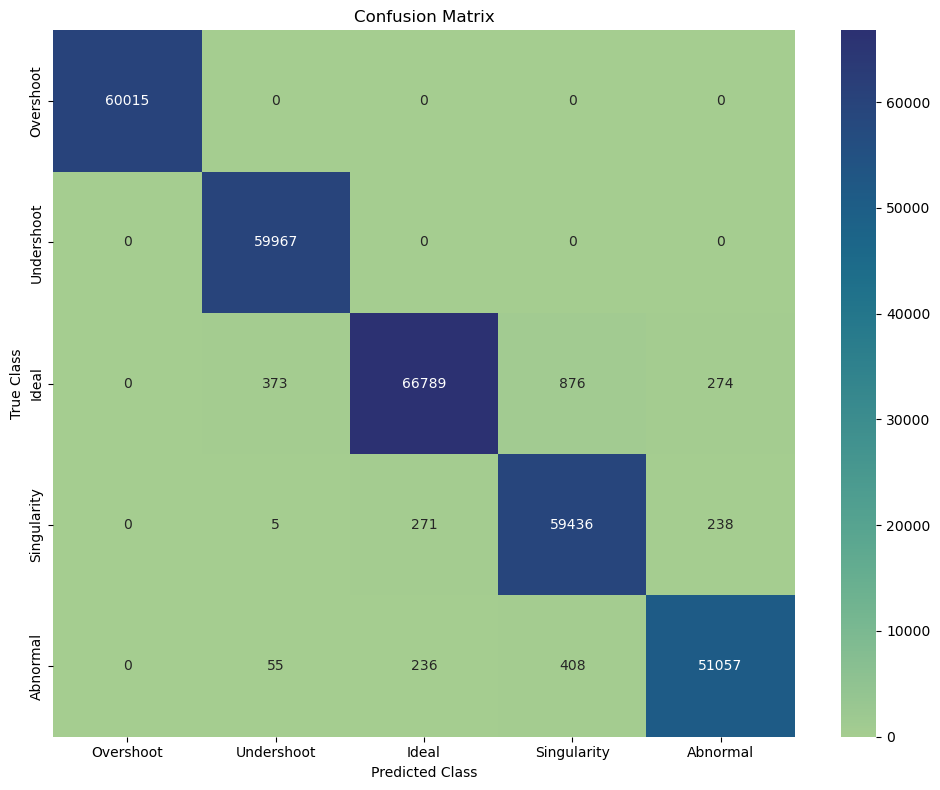

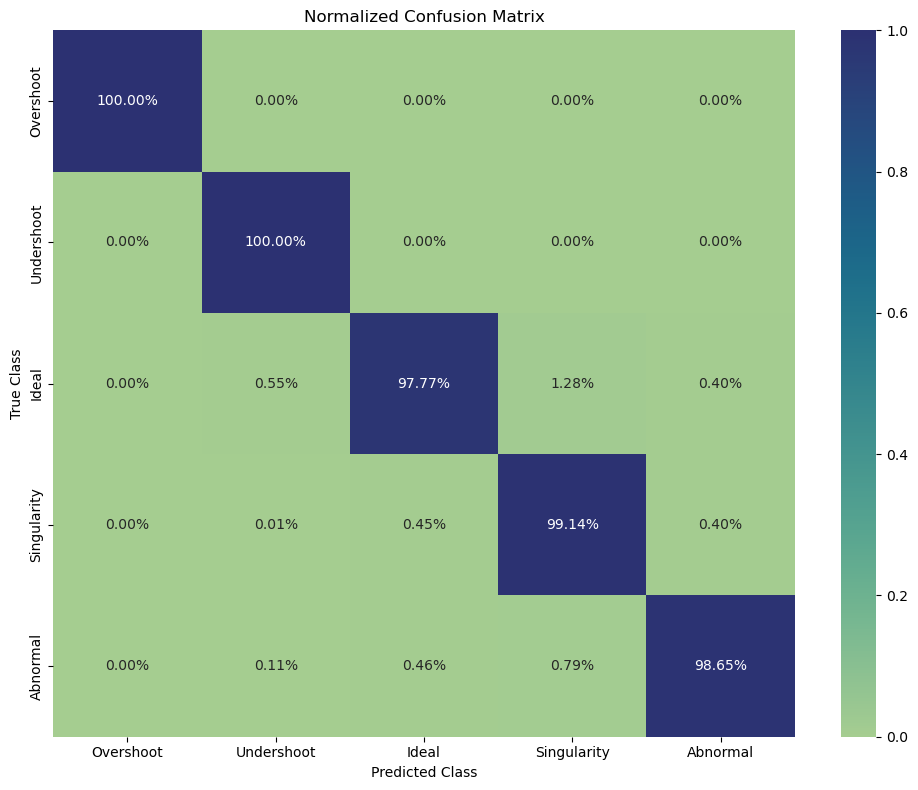

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true=test_df['trueClass'], y_pred=test_df['predicted_class'])

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
            xticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'],  # If your classes are 0-4
            yticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])  # If your classes are 0-4

# Add labels
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

# Show plot
plt.tight_layout()
plt.show()

# If you want to normalize the confusion matrix (show percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='crest',
            xticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'],
            yticklabels=['Overshoot', 'Undershoot', 'Ideal', 'Singularity', 'Abnormal'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()
# {'class_1': 'Overshoot', 'class_2': 'Undershoot', 'class_3': 'Ideal', 'class_4': 'Singularity', 'class_5': 'Abnormal'}

In [ ]:
(100+100+92.43+86.66+94.90)/5